# Experiment 3: Selection Bias and Batch Effects

In this experiment, we combine selection bias and batch effects. The AIRR data comes from 2 hospitals: `hospital1` that recruits mostly diseased and `hospital2` that recruits mostly healthy individuals. We explore three possible scenarios here:

1. the immune state signal is stronger than the influence of the experimental protocol used for AIRR-sequencing,

2. the immune state signal is weaker than the influence of the experimental protocol,

3. there is no connection between the immune state and AIRR: we will show that ML models will in this case learn only a spurious correlation.

Immune state is a binary variable and can have values `True` or `False` to indicate if an individual is diseased or healthy. AIRR is a set of sequences simulated based on the values of the immune state and the confounder for the given individual. Hospital is a binary variable (`hospital1` or `hospital2`). Each hospital has their own experimental protocol that influences the observed AIRR. The influence of the experimental protocol on AIRR is manifested via higher frequency of some k-mers in the sequenced AIRRs.

Steps for each scenario:

1. Simulate training and test dataset from a causal graph to include the variables as described above.

2. Train an ML model (here: logistic regression on repertoires represented by the k-mer frequencies) on the train set which has selection bias and assess its performance on the test set when there is no selection bias.

Software used: 

- DagSim for simulation of the causal graph; 
- immuneML v2.1 for implanting signal in AIRRs and for training and assessing machine learning classifiers; 
- OLGA for simulation of naive AIRRs

In [1]:
import os
import yaml
import dagsim.baseDS as ds
import numpy as np
from pathlib import Path
from util.repertoire_util import make_olga_repertoire, load_iml_repertoire, make_AIRR_dataset, make_dataset
from util.implanting import make_immune_signal, make_repertoire_without_signal, make_repertoire_with_signal, make_exp_protocol_signal
from util.simulation import get_immune_state, get_hospital, get_exp_protocol, get_repertoire, get_selection
from immuneML.util.PathBuilder import PathBuilder
from immuneML.simulation.implants.Signal import Signal

In [2]:
# remove results from the previous run

import shutil

if Path("./experiment3/").is_dir():
    shutil.rmtree("./experiment3/")
    
# define number of examples (AIRRs)

train_example_count = 10
test_example_count = 2

# immune state: two binomial distributions depending on the confounder value with probability of success p
immune_state_p_conf0 = 0.3 # for confounder = 0
immune_state_p_conf1 = 0.5 # for confounder = 1

# confounder: binomial distribution with probability of success p
confounder_p = 0.5

# other parameters
repertoire_implanting_rate = 0.01 # percentage of repertoire sequences to include immune state signal
sequence_count = 2000 # number of sequences in one repertoire

## Scenario 1: immune state signal is stronger than the influence of experimental protocol

In [3]:
# define and build path, remove content if not empty

scenario1_path = Path("./experiment3/scenario1/")

if scenario1_path.is_dir():
    shutil.rmtree(scenario1_path)
    
PathBuilder.build(scenario1_path)

data_path = PathBuilder.build(scenario1_path / "data")

### Step 1: AIRR simulation from a causal graph

In [4]:
# define constants for the simulation

p_immune_state = 0.5 # parameter of binomial distribution for the immune state
p_hospital = 0.5 # parameter of binomial distribution for selecting between hospitals 1 and 2

sequence_count = 2000
repertoire_implanting_rate = 0.01

immune_state_signal = make_immune_signal()

In [5]:
immune_state_node = ds.Generic(name="immune_state", function=get_immune_state, arguments={"p": p_immune_state})

hospital_node = ds.Generic(name="hospital", function=get_hospital, arguments={"p": p_hospital})

experimental_protocol_node = ds.Generic(name="exp_protocol", function=get_exp_protocol, arguments={"hospital": hospital_node})

repertoire_node = ds.Generic(name="repertoire", function=get_repertoire, 
                             arguments={"immune_state": immune_state_node, "experimental_protocol": experimental_protocol_node,
                                        "path": data_path / "train", "sequence_count": sequence_count, "immune_state_signal": immune_state_signal, 
                                        'repertoire_implanting_rate': repertoire_implanting_rate})

selection_node = ds.Selection(name="S", function=get_selection, arguments={"hospital": hospital_node, "immune_state": immune_state_node})

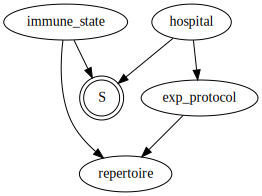

In [6]:
# make a causal graph using DagSim and show it graphically

graph = ds.Graph(name="graph_experiment_3_1", list_nodes=[immune_state_node, hospital_node, experimental_protocol_node, repertoire_node, selection_node])
graph.draw()

In [7]:
training_data_sc1 = graph.simulate(num_samples=train_example_count, csv_name=str(data_path / "train/study_cohort"))


In [8]:
# make an AIRR dataset from the generated repertoires to be used for training

repertoires = [load_iml_repertoire(filepath=filepath) for filepath in training_data_sc1["repertoire"]]

train_dataset = make_dataset(repertoires=repertoires, path=data_path / 'train', dataset_name="experiment3_sc1_train",
                             signal_names=[immune_state_signal.id, experimental_protocol_node.name])

In [9]:
# make a test dataset

repertoire_node.additional_parameters['path'] = data_path / 'test' # update result_path: to be removed with DagSim update

test_data = graph.simulate(num_samples=test_example_count, csv_name=str(data_path / "test/test_cohort"), selection=False)

test_repertoires = [load_iml_repertoire(filepath=filepath) for filepath in test_data["repertoire"]]

test_dataset = make_dataset(repertoires=test_repertoires, path=data_path / 'test',
                            dataset_name="experiment3_sc1_test", signal_names=[immune_state_signal.id, experimental_protocol_node.name])


In [10]:
# merge datasets (but the distinction between train and test will be kept in the ML analysis part)

dataset = make_AIRR_dataset(train_dataset, test_dataset, data_path / 'full_dataset')

### Step 2: Training an ML model

## Scenario 3: immune state does not influence the repertoire

In [ ]:
# define and build path, remove content if not empty

scenario3_path = Path("./experiment3/scenario3/")

if scenario3_path.is_dir():
    shutil.rmtree("./experiment3/scenario3/")

PathBuilder.build(scenario3_path)

data_path = PathBuilder.build(scenario3_path / "data")

# repertoire_node.additional_parameters["path"] = data_path / "train"
# repertoire_node.additional_parameters["immune_state"] = 0
# repertoire_node.parents.pop(repertoire_node.parents.index("immune_state"))
repertoire_node = ds.Generic(name="repertoire", function=get_repertoire,
                             arguments={"immune_state": False, "experimental_protocol": experimental_protocol_node,
                                        "path": data_path / "train", "sequence_count": sequence_count, "immune_state_signal": immune_state_signal,
                                        'repertoire_implanting_rate': repertoire_implanting_rate})

In [ ]:

# make a causal graph using DagSim and show it graphically

graph = ds.Graph(name="graph_experiment_3_3", list_nodes=[index_node, immune_state_node, hospital_node, experimental_protocol_node, repertoire_node, selection_node])
graph.draw()

In [ ]:
training_data_sc1 = graph.simulate(num_samples=train_example_count, csv_name=str(data_path / "train/study_cohort"))


In [ ]:
# make an AIRR dataset from the generated repertoires to be used for training

repertoires = [load_iml_repertoire(filepath=filepath) for filepath in training_data_sc1["repertoire"]]

train_dataset = make_dataset(repertoires=repertoires, path=data_path / 'train', dataset_name="experiment3_sc3_train",
                             signal_names=[immune_state_signal.id, experimental_protocol_node.name])

In [ ]:
# make a test dataset

repertoire_node.additional_parameters['path'] = data_path / 'test' # update result_path: to be removed with DagSim update

test_data = graph.simulate(num_samples=test_example_count, csv_name=str(data_path / "test/test_cohort"), selection=False)

test_repertoires = [load_iml_repertoire(filepath=filepath) for filepath in test_data["repertoire"]]

test_dataset = make_dataset(repertoires=test_repertoires, path=data_path / 'test',
                            dataset_name="experiment3_sc3_test", signal_names=[immune_state_signal.id, experimental_protocol_node.name])


In [ ]:
# merge datasets (but the distinction between train and test will be kept in the ML analysis part)

dataset = make_AIRR_dataset(train_dataset, test_dataset, data_path / 'full_dataset')